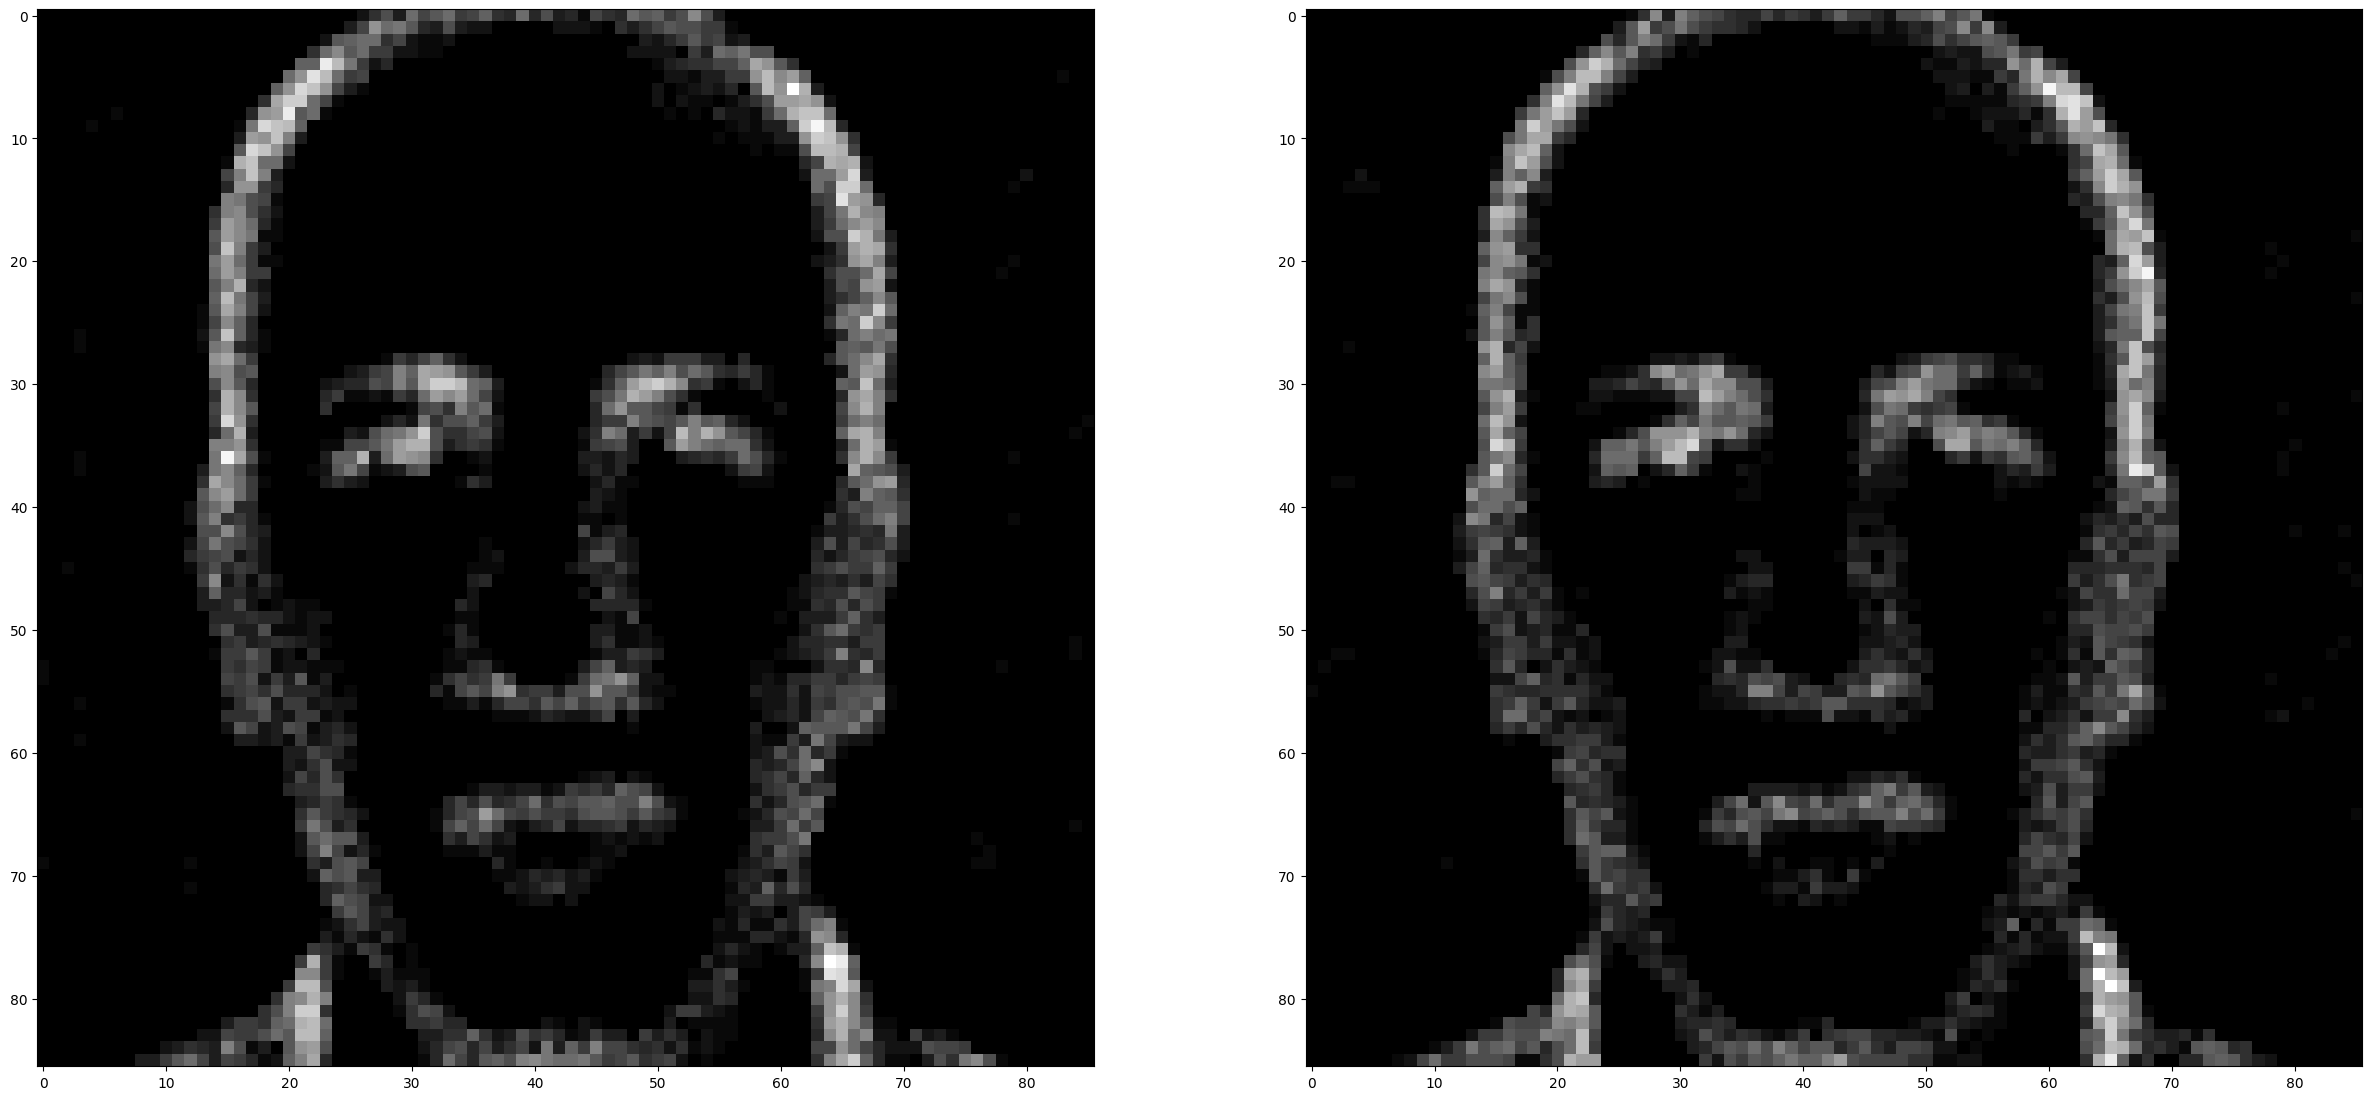

In [26]:
from pymonntorch import (
    NeuronGroup, SynapseGroup, 
    NeuronDimension, Recorder, Behavior,
    EventRecorder,
)
from conex import (
    Neocortex,
    InputLayer,
    Synapsis,
    prioritize_behaviors,
)

from conex.behaviors.neurons import (
    SimpleDendriteStructure,
    SimpleDendriteComputation,
    LIF,
    SpikeTrace,
    NeuronAxon,
    Fire,
    KWTA,
)

from conex.behaviors.neurons.homeostasis import (
    VoltageBaseHomeostasis,
    ActivityBaseHomeostasis,
)

from conex.behaviors.synapses import (
    SynapseInit,
    WeightInitializer,
    SimpleDendriticInput,
    SimpleSTDP,
    Conv2dDendriticInput,
    Conv2dSTDP,
    LateralDendriticInput,
    WeightClip,
    WeightNormalization,
)

from conex.helpers.transforms.encoders import SimplePoisson, Intensity2Latency
from conex.helpers.transforms.misc import Conv2dFilter
from conex.helpers.filters import DoGFilter, GaborFilter
from conex.helpers.transforms.misc import SqueezeTransform

import torch, random, os, sys, time, math
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

import plotly.graph_objects as go
import plotly.express as px

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from colorit import *
init_colorit()

class FaceDataset(Dataset):
    def __init__(self, root_dir, transform = None) -> None:
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image



ITERATIONS = 500 

R = 5
THRESHOLD = -65
TAU = 10
V_RESET = -68
V_REST = -67
V_INIT = -50
       
K = 1
KW_DIMENSION = 0

MODE = 'normal(0.5, 0.01)'
APLUS = 0.5
AMINUS = 0.003
WMIN = 0
WMAX = 1
CURRENT_COEFF = 10

IMG_HEIGHT = 100
IMG_WIDTH  = 100

TIME_WINDOW = 45
POISSON_RATIO = 2
FILTER_SIZE = 15
SIGMA1 = 10
SIGMA2 = 1

FEATURES_CNT = 20

LAYER_ONE_HEIGHT = IMG_HEIGHT - FILTER_SIZE + 1
LAYER_ONE_WIDTH  = IMG_WIDTH  - FILTER_SIZE + 1

WEIGHT_DEPTH  = KERNEL_DEPTH  = FEATURES_CNT
WEIGHT_HEIGHT = KERNEL_HEIGHT = 10
WEIGHT_WIDTH  = KERNEL_WIDTH  = 10
WEIGHT_SHAPE  = KERNEL_SHAPE  = (KERNEL_DEPTH, 1, KERNEL_HEIGHT, KERNEL_WIDTH)

LAYER_TWO_DEPTH  = FEATURES_CNT
LAYER_TWO_HEIGHT = LAYER_ONE_HEIGHT - KERNEL_HEIGHT + 1
LAYER_TWO_WIDTH  = LAYER_ONE_WIDTH  - KERNEL_WIDTH  + 1


NORM = (KERNEL_HEIGHT * KERNEL_WIDTH) / 2
    
def SHOW_PARAMS():
    print(color("ITERATIONS:         ", Colors.green), ITERATIONS, end = '\t\t\t\t\t')
    print(color("TIME_WINDOW:        ", Colors.blue), TIME_WINDOW)

    print(color("R:                  ", Colors.orange), R, end = '\t\t\t\t\t\t')
    print(color("IMG_HEIGHT:         ", Colors.blue), IMG_HEIGHT)


    print(color("THRESHOLD:          ", Colors.orange), THRESHOLD, end = '\t\t\t\t\t')    
    print(color("IMG_WIDTH:          ", Colors.blue), IMG_WIDTH)


    print(color("TAU:                ", Colors.orange), TAU, end = '\t\t\t\t\t\t')
    print(color("FILTER_SIZE:        ", Colors.blue), FILTER_SIZE)



    print(color("V_RESET:            ", Colors.orange), V_RESET, end = '\t\t\t\t\t')
    print(color("FEATURES_CNT:       ", Colors.blue), FEATURES_CNT)


    print(color("V_REST:             ", Colors.orange), V_REST, end = '\t\t\t\t\t')
    print(color("LAYER_ONE_HEIGHT:   ", Colors.blue), LAYER_ONE_HEIGHT)


    print(color("V_INIT:             ", Colors.orange), V_INIT, end = '\t\t\t\t\t')
    print(color("LAYER_ONE_WIDTH:    ", Colors.blue), LAYER_ONE_WIDTH)

    
    print(color("K:                  ", Colors.purple), K, end = '\t\t\t\t\t\t')
    print(color("WEIGHT_DEPTH:       ", Colors.blue), WEIGHT_DEPTH)


    print(color("MU:                 ", Colors.purple), MU, end = '\t\t\t\t\t')
    print(color("WEIGHT_HEIGHT:      ", Colors.blue), WEIGHT_HEIGHT)


    print(color("SIG:                ", Colors.purple), SIG, end = '\t\t\t\t\t')
    print(color("WEIGHT_WIDTH:       ", Colors.blue), WEIGHT_WIDTH)


    print(color("APLUS:              ", Colors.purple), APLUS, end = '\t\t\t\t\t\t')
    print(color("WEIGHT_SHAPE:       ", Colors.blue), WEIGHT_SHAPE)


    print(color("AMINUS:             ", Colors.purple), AMINUS, end = '\t\t\t\t\t\t')
    print(color("KERNEL_SHAPE:       ", Colors.blue), KERNEL_SHAPE)


    print(color("WMIN:               ", Colors.purple), WMIN, end = '\t\t\t\t\t\t')
    print(color("LAYER_TWO_DEPTH:    ", Colors.blue), LAYER_TWO_DEPTH)


    print(color("WMAX:               ", Colors.purple), WMAX, end = '\t\t\t\t\t\t')
    print(color("LAYER_TWO_HEIGHT:   ", Colors.blue), LAYER_TWO_HEIGHT)


    print(color("CURRENT_COEFF:      ", Colors.purple), CURRENT_COEFF, end = '\t\t\t\t\t\t')
    print(color("LAYER_TWO_WIDTH:    ", Colors.blue), LAYER_TWO_WIDTH)
# SHOW_PARAMS()


dog_filter = DoGFilter(size = FILTER_SIZE, sigma_1 = SIGMA1, sigma_2 = SIGMA2, device = "cpu", dtype=torch.float32, zero_mean = True, one_sum = True)
conv = Conv2dFilter(dog_filter.unsqueeze(0).unsqueeze(0), stride = 1, padding = 0)
ttfs = Intensity2Latency(time_window = TIME_WINDOW, threshold = 0.1, sparsity = 0.15)
poisson = SimplePoisson(time_window = TIME_WINDOW, ratio = POISSON_RATIO)
encoder = poisson
transformation = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels = 1),
    conv,
    encoder,
    SqueezeTransform(dim = 1),
])

dataset = FaceDataset(root_dir = "./data/faces", transform = transformation)
NUM_SAMPLES = 1
# indices = random.sample(range(len(dataset)), NUM_SAMPLES)
# indices = [51, 71, 80, 67, 13, 14, 90, 60, 12, 41]
indices = [500] * 2
data_subset = torch.utils.data.Subset(dataset, indices)
dataloader = DataLoader(dataset = data_subset, batch_size = len(indices), shuffle = True)

img2show = data_subset[0].cpu()
# plt.imshow(img2show.sum(0), cmap='gray'); plt.show()
"""fig = go.Figure(data=[go.Scatter3d(
    x=img2show.nonzero(as_tuple=True)[2],
    y=img2show.nonzero(as_tuple=True)[1],
    z=img2show.nonzero(as_tuple=True)[0],
    mode='markers',
    marker=dict(
        size=2,
        color='black',                
        colorscale='Viridis',   
        opacity=0.8
    )
)])
fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Time'),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10)) ;fig.show()"""

fig, axs = plt.subplots(1, len(data_subset), figsize=(30, 30))
for i, data in enumerate(data_subset):
    img = data.cpu().sum(0)
    axs[i].imshow(img, cmap='gray')
plt.show()
    

In [27]:
net = Neocortex(dt = 1, device = "cpu", dtype = torch.float32)
input_layer = InputLayer(
    net = net,
    input_dataloader = dataloader,
    have_sensory = True,
    have_location = False,
    have_label = False,
    sensory_data_dim = 2,
    sensory_size = NeuronDimension(depth = 1, height = LAYER_ONE_HEIGHT, width = LAYER_ONE_WIDTH),
    sensory_trace = 2.7,
    instance_duration = TIME_WINDOW,
    silent_interval = 5,
)

pop_exc = NeuronGroup(
    net = net,
    size = NeuronDimension(depth = LAYER_TWO_DEPTH, height = LAYER_TWO_HEIGHT, width = LAYER_TWO_WIDTH),
    behavior = prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                    R = R,
                    threshold = THRESHOLD,
                    tau = TAU,
                    v_reset = V_RESET,
                    v_rest = V_REST,
                    init_v = V_INIT,
                ),
            KWTA(k = K, dimension = KW_DIMENSION),
            SpikeTrace(tau_s = 10),
            NeuronAxon(),
            Fire(),
            # ActivityBaseHomeostasis(window_size = 100, activity_rate = 20, updating_rate = 0.01, decay_rate = 1),
            Recorder(tag = "exc_recorder", variables = ["v", "I"]),
            EventRecorder(tag = "synapse_event_recorder", variables = ["spikes"]),
        ]
    )
)

synapse = SynapseGroup(
    net = net,
    src = input_layer.sensory_pop,
    dst = pop_exc,
    tag = "Proximal",
    behavior = prioritize_behaviors(
        [
            SynapseInit(),  
            WeightInitializer(mode = MODE, weight_shape = WEIGHT_SHAPE, kernel_shape = KERNEL_SHAPE),
            Conv2dDendriticInput(current_coef = CURRENT_COEFF),
            Conv2dSTDP(a_minus = AMINUS, a_plus = APLUS),
            WeightClip(w_min = WMIN, w_max = WMAX),
            WeightNormalization(norm = NORM),
            Recorder(tag = "synapse_recorder", variables = ["weights", "I"]),
        ]
    )
)

lateral_connection = SynapseGroup(
    net = net,
    src = pop_exc,
    dst = pop_exc,
    tag = "Proximal, inh",
    behavior = prioritize_behaviors(
        [
            SynapseInit(),  
            WeightInitializer(mode = 0.5, weight_shape = (1, 1, 1 + 2*1, 1 + 2*2, 1 + 2*2)),
            LateralDendriticInput(inhibitory = True, current_coef = 500),
        ]
    )
)

net.initialize(info = False)
net.simulate_iterations(ITERATIONS)

100%|██████████| 500/500 [00:29<00:00, 17.02it/s]

500xBatch: 1/1 (100%) 29372.205ms


29372.205018997192

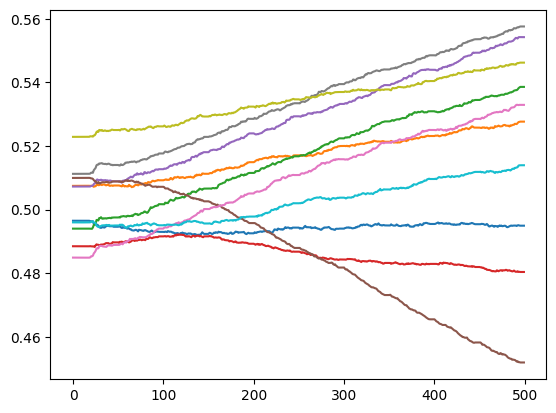

In [28]:
weights = net["synapse_recorder", 0].variables["weights"].squeeze(2)
weights = weights[:, 0, :, :]
for k in range(1, WEIGHT_HEIGHT + 1):
    for j in range(1, WEIGHT_WIDTH + 1):
        rnd = random.randint(0, ITERATIONS)
        if rnd % 10 == 0: plt.plot([i for i in range(ITERATIONS)], torch.flatten(weights[:,k-1:k,j-1:j]), label=f"W{k}{j}")
        else:            pass
plt.show()


# plt.scatter(net["spikes", 0][:, 0], net["spikes", 0][:, 1], s = 0.25)
# plt.show()

# current = net["exc_recorder", 0].variables["I"].squeeze(1).squeeze(1)
# plt.plot(current[:, :])
# plt.show()

# voltage = net["exc_recorder", 0].variables["v"]
# plt.plot(voltage[:, :100])
# plt.show()

# syn_current = net["synapse_recorder", 0].variables["I"].squeeze(1).squeeze(1)
# plt.plot(syn_current[:, :])
# plt.show()


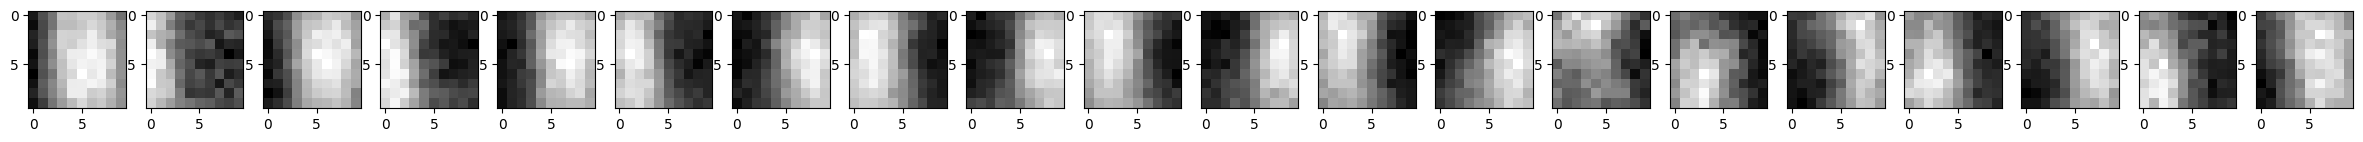

In [29]:
fig, axs = plt.subplots(1, FEATURES_CNT, figsize=(30, 15))
if FEATURES_CNT == 1: axs = [axs]
for i in range(FEATURES_CNT):
    feature_img = synapse.weights[i].squeeze(0)
    axs[i].imshow(feature_img, cmap='gray')
plt.show()

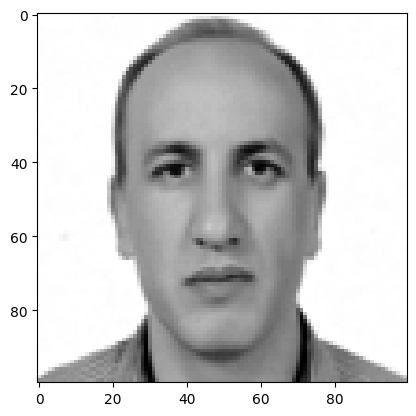

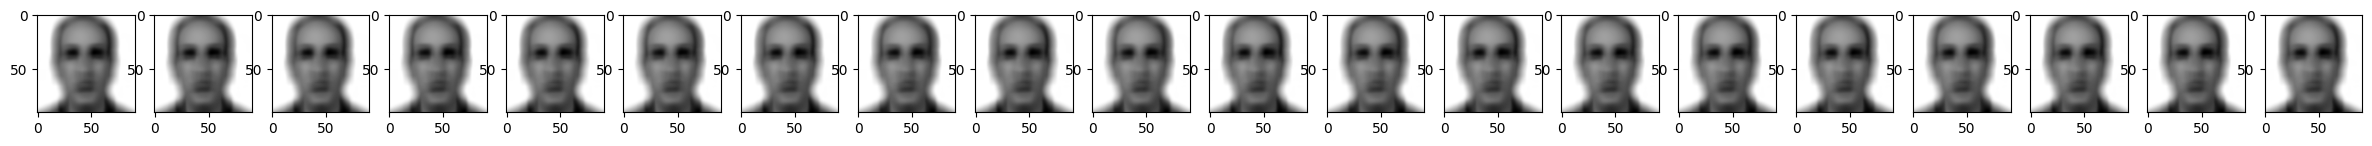

In [30]:
image = Image.open("./data/faces/000501.jpg").convert('L').resize((IMG_HEIGHT, IMG_WIDTH))
plt.imshow(image, cmap='gray')
plt.show()

fig, axs = plt.subplots(1, FEATURES_CNT, figsize=(30, 15))
for i in range(FEATURES_CNT):
    image = Image.open("./data/faces/000501.jpg").convert('L').resize((IMG_HEIGHT, IMG_WIDTH))  
    image = transforms.ToTensor()(image).unsqueeze(0)
    w = synapse.weights[i].squeeze(0)
    c = F.conv2d(image, w.unsqueeze(0).unsqueeze(0), padding = 0, stride = 1)
    axs[i].imshow(c.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')
plt.show()